##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 使用 TFL 层创建 Keras 模型

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/lattice/tutorials/keras_layers"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看 </a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/lattice/tutorials/keras_layers.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/lattice/tutorials/keras_layers.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 中查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/lattice/tutorials/keras_layers.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png"> 下载笔记本</a></td>
</table>

##概述

您可以使用 TFL Keras 层构造具有单调性和其他形状约束的 Keras 模型。本示例将使用 TFL 层为 UCI 心脏数据集构建并训练一个校准点阵模型。

在校准点阵模型中，每个特征都由 `tfl.layers.PWLCalibration` 或 `tfl.layers.CategoricalCalibration` 层转换，然后使用 `tfl.layers.Lattice` 将结果以非线性方式融合。

## 设置

安装 TF Lattice 软件包：

In [2]:
#@test {"skip": true}
!pip install tensorflow-lattice pydot

  Using cached tensorflow_lattice-2.0.9-py2.py3-none-any.whl (235 kB)


  Using cached dm_sonnet-2.0.0-py3-none-any.whl (254 kB)


  Using cached graphviz-0.17-py3-none-any.whl (18 kB)


  Using cached dm_tree-0.1.6-cp37-cp37m-manylinux_2_24_x86_64.whl (93 kB)
  Using cached tabulate-0.8.9-py3-none-any.whl (25 kB)


导入所需的软件包：

In [3]:
import tensorflow as tf

import logging
import numpy as np
import pandas as pd
import sys
import tensorflow_lattice as tfl
from tensorflow import feature_column as fc
logging.disable(sys.maxsize)

下载 UCI Statlog (Heart) 数据集：

In [4]:
# UCI Statlog (Heart) dataset.
csv_file = tf.keras.utils.get_file(
    'heart.csv', 'http://storage.googleapis.com/download.tensorflow.org/data/heart.csv')
training_data_df = pd.read_csv(csv_file).sample(
    frac=1.0, random_state=41).reset_index(drop=True)
training_data_df.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   61    1   4       120   260    0        0      140      1      3.6      2   
1   45    1   3       110   264    0        1      132      0      1.2      1   
2   47    1   3       130   253    0        0      179      0      0.0      1   
3   59    1   3       150   212    1        0      157      0      1.6      1   
4   55    0   4       128   205    0        1      130      1      2.0      2   

   ca        thal  target  
0   1  reversible       1  
1   0      normal       0  
2   0      normal       0  
3   0      normal       0  
4   1  reversible       1

设置用于在本指南中进行训练的默认值：

In [5]:
LEARNING_RATE = 0.1
BATCH_SIZE = 128
NUM_EPOCHS = 100

## Keras 序贯模型

本示例将创建一个 Keras 序贯模型，并且仅使用 TFL 层。

点阵层期望 `input[i]` 处于 `[0, lattice_sizes[i] - 1.0]` 范围内，因此我们需要在校准层之前定义点阵大小，以便能够正确指定校准层的输出范围。


In [6]:
# Lattice layer expects input[i] to be within [0, lattice_sizes[i] - 1.0], so
lattice_sizes = [3, 2, 2, 2, 2, 2, 2]

我们使用 `tfl.layers.ParallelCombination` 层将校准层组合在一起，这些校准层必须并行执行才能创建序贯模型。


In [7]:
combined_calibrators = tfl.layers.ParallelCombination()

我们为每个特征创建一个校准层，并将其添加到并行组合层。对于数字特征，我们使用 `tfl.layers.PWLCalibration`，对于分类特征，我们使用 `tfl.layers.CategoricalCalibration`。

In [8]:
# ############### age ###############
calibrator = tfl.layers.PWLCalibration(
    # Every PWLCalibration layer must have keypoints of piecewise linear
    # function specified. Easiest way to specify them is to uniformly cover
    # entire input range by using numpy.linspace().
    input_keypoints=np.linspace(
        training_data_df['age'].min(), training_data_df['age'].max(), num=5),
    # You need to ensure that input keypoints have same dtype as layer input.
    # You can do it by setting dtype here or by providing keypoints in such
    # format which will be converted to desired tf.dtype by default.
    dtype=tf.float32,
    # Output range must correspond to expected lattice input range.
    output_min=0.0,
    output_max=lattice_sizes[0] - 1.0,
)
combined_calibrators.append(calibrator)

# ############### sex ###############
# For boolean features simply specify CategoricalCalibration layer with 2
# buckets.
calibrator = tfl.layers.CategoricalCalibration(
    num_buckets=2,
    output_min=0.0,
    output_max=lattice_sizes[1] - 1.0,
    # Initializes all outputs to (output_min + output_max) / 2.0.
    kernel_initializer='constant')
combined_calibrators.append(calibrator)

# ############### cp ###############
calibrator = tfl.layers.PWLCalibration(
    # Here instead of specifying dtype of layer we convert keypoints into
    # np.float32.
    input_keypoints=np.linspace(1, 4, num=4, dtype=np.float32),
    output_min=0.0,
    output_max=lattice_sizes[2] - 1.0,
    monotonicity='increasing',
    # You can specify TFL regularizers as a tuple ('regularizer name', l1, l2).
    kernel_regularizer=('hessian', 0.0, 1e-4))
combined_calibrators.append(calibrator)

# ############### trestbps ###############
calibrator = tfl.layers.PWLCalibration(
    # Alternatively, you might want to use quantiles as keypoints instead of
    # uniform keypoints
    input_keypoints=np.quantile(training_data_df['trestbps'],
                                np.linspace(0.0, 1.0, num=5)),
    dtype=tf.float32,
    # Together with quantile keypoints you might want to initialize piecewise
    # linear function to have 'equal_slopes' in order for output of layer
    # after initialization to preserve original distribution.
    kernel_initializer='equal_slopes',
    output_min=0.0,
    output_max=lattice_sizes[3] - 1.0,
    # You might consider clamping extreme inputs of the calibrator to output
    # bounds.
    clamp_min=True,
    clamp_max=True,
    monotonicity='increasing')
combined_calibrators.append(calibrator)

# ############### chol ###############
calibrator = tfl.layers.PWLCalibration(
    # Explicit input keypoint initialization.
    input_keypoints=[126.0, 210.0, 247.0, 286.0, 564.0],
    dtype=tf.float32,
    output_min=0.0,
    output_max=lattice_sizes[4] - 1.0,
    # Monotonicity of calibrator can be decreasing. Note that corresponding
    # lattice dimension must have INCREASING monotonicity regardless of
    # monotonicity direction of calibrator.
    monotonicity='decreasing',
    # Convexity together with decreasing monotonicity result in diminishing
    # return constraint.
    convexity='convex',
    # You can specify list of regularizers. You are not limited to TFL
    # regularizrs. Feel free to use any :)
    kernel_regularizer=[('laplacian', 0.0, 1e-4),
                        tf.keras.regularizers.l1_l2(l1=0.001)])
combined_calibrators.append(calibrator)

# ############### fbs ###############
calibrator = tfl.layers.CategoricalCalibration(
    num_buckets=2,
    output_min=0.0,
    output_max=lattice_sizes[5] - 1.0,
    # For categorical calibration layer monotonicity is specified for pairs
    # of indices of categories. Output for first category in pair will be
    # smaller than output for second category.
    #
    # Don't forget to set monotonicity of corresponding dimension of Lattice
    # layer to '1'.
    monotonicities=[(0, 1)],
    # This initializer is identical to default one('uniform'), but has fixed
    # seed in order to simplify experimentation.
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=0.0, maxval=lattice_sizes[5] - 1.0, seed=1))
combined_calibrators.append(calibrator)

# ############### restecg ###############
calibrator = tfl.layers.CategoricalCalibration(
    num_buckets=3,
    output_min=0.0,
    output_max=lattice_sizes[6] - 1.0,
    # Categorical monotonicity can be partial order.
    monotonicities=[(0, 1), (0, 2)],
    # Categorical calibration layer supports standard Keras regularizers.
    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001),
    kernel_initializer='constant')
combined_calibrators.append(calibrator)

随后，我们创建一个点阵层来以非线性方式融合校准器的输出。

请注意，我们需要指定要为所需维度增加的点阵单调性。在校准中具有单调性方向的成分将产生正确的端到端单调性方向。这包括 CategoricalCalibration 层的部分单调性。

In [9]:
lattice = tfl.layers.Lattice(
    lattice_sizes=lattice_sizes,
    monotonicities=[
        'increasing', 'none', 'increasing', 'increasing', 'increasing',
        'increasing', 'increasing'
    ],
    output_min=0.0,
    output_max=1.0)

然后，我们可以使用校准器和点阵层的组合创建一个序贯模型。

In [10]:
model = tf.keras.models.Sequential()
model.add(combined_calibrators)
model.add(lattice)

训练的工作原理与其他任何 Keras 模型相同。

In [11]:
features = training_data_df[[
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg'
]].values.astype(np.float32)
target = training_data_df[['target']].values.astype(np.float32)

model.compile(
    loss=tf.keras.losses.mean_squared_error,
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=LEARNING_RATE))
model.fit(
    features,
    target,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_split=0.2,
    shuffle=False,
    verbose=0)

model.evaluate(features, target)

 1/10 [==>...........................] - ETA: 0s - loss: 0.1265

10/10 [==============================] - 0s 2ms/step - loss: 0.1551


0.1550564467906952

## Keras 函数式模型

本示例使用函数式 API 来构造 Keras 模型。

如上一部分中所述，点阵层期望 `input[i]` 处于 `[0, lattice_sizes[i] - 1.0]` 范围内，因此我们需要在校准层之前定义点阵大小，以便能够正确指定校准层的输出范围。

In [12]:
# We are going to have 2-d embedding as one of lattice inputs.
lattice_sizes = [3, 2, 2, 3, 3, 2, 2]

对于每个特征，我们需要创建一个输入层，后面跟随校准层。对于数字特征，我们使用 `tfl.layers.PWLCalibration`，对于分类特征，我们使用 `tfl.layers.CategoricalCalibration`。

In [13]:
model_inputs = []
lattice_inputs = []
# ############### age ###############
age_input = tf.keras.layers.Input(shape=[1], name='age')
model_inputs.append(age_input)
age_calibrator = tfl.layers.PWLCalibration(
    # Every PWLCalibration layer must have keypoints of piecewise linear
    # function specified. Easiest way to specify them is to uniformly cover
    # entire input range by using numpy.linspace().
    input_keypoints=np.linspace(
        training_data_df['age'].min(), training_data_df['age'].max(), num=5),
    # You need to ensure that input keypoints have same dtype as layer input.
    # You can do it by setting dtype here or by providing keypoints in such
    # format which will be converted to desired tf.dtype by default.
    dtype=tf.float32,
    # Output range must correspond to expected lattice input range.
    output_min=0.0,
    output_max=lattice_sizes[0] - 1.0,
    monotonicity='increasing',
    name='age_calib',
)(
    age_input)
lattice_inputs.append(age_calibrator)

# ############### sex ###############
# For boolean features simply specify CategoricalCalibration layer with 2
# buckets.
sex_input = tf.keras.layers.Input(shape=[1], name='sex')
model_inputs.append(sex_input)
sex_calibrator = tfl.layers.CategoricalCalibration(
    num_buckets=2,
    output_min=0.0,
    output_max=lattice_sizes[1] - 1.0,
    # Initializes all outputs to (output_min + output_max) / 2.0.
    kernel_initializer='constant',
    name='sex_calib',
)(
    sex_input)
lattice_inputs.append(sex_calibrator)

# ############### cp ###############
cp_input = tf.keras.layers.Input(shape=[1], name='cp')
model_inputs.append(cp_input)
cp_calibrator = tfl.layers.PWLCalibration(
    # Here instead of specifying dtype of layer we convert keypoints into
    # np.float32.
    input_keypoints=np.linspace(1, 4, num=4, dtype=np.float32),
    output_min=0.0,
    output_max=lattice_sizes[2] - 1.0,
    monotonicity='increasing',
    # You can specify TFL regularizers as tuple ('regularizer name', l1, l2).
    kernel_regularizer=('hessian', 0.0, 1e-4),
    name='cp_calib',
)(
    cp_input)
lattice_inputs.append(cp_calibrator)

# ############### trestbps ###############
trestbps_input = tf.keras.layers.Input(shape=[1], name='trestbps')
model_inputs.append(trestbps_input)
trestbps_calibrator = tfl.layers.PWLCalibration(
    # Alternatively, you might want to use quantiles as keypoints instead of
    # uniform keypoints
    input_keypoints=np.quantile(training_data_df['trestbps'],
                                np.linspace(0.0, 1.0, num=5)),
    dtype=tf.float32,
    # Together with quantile keypoints you might want to initialize piecewise
    # linear function to have 'equal_slopes' in order for output of layer
    # after initialization to preserve original distribution.
    kernel_initializer='equal_slopes',
    output_min=0.0,
    output_max=lattice_sizes[3] - 1.0,
    # You might consider clamping extreme inputs of the calibrator to output
    # bounds.
    clamp_min=True,
    clamp_max=True,
    monotonicity='increasing',
    name='trestbps_calib',
)(
    trestbps_input)
lattice_inputs.append(trestbps_calibrator)

# ############### chol ###############
chol_input = tf.keras.layers.Input(shape=[1], name='chol')
model_inputs.append(chol_input)
chol_calibrator = tfl.layers.PWLCalibration(
    # Explicit input keypoint initialization.
    input_keypoints=[126.0, 210.0, 247.0, 286.0, 564.0],
    output_min=0.0,
    output_max=lattice_sizes[4] - 1.0,
    # Monotonicity of calibrator can be decreasing. Note that corresponding
    # lattice dimension must have INCREASING monotonicity regardless of
    # monotonicity direction of calibrator.
    monotonicity='decreasing',
    # Convexity together with decreasing monotonicity result in diminishing
    # return constraint.
    convexity='convex',
    # You can specify list of regularizers. You are not limited to TFL
    # regularizrs. Feel free to use any :)
    kernel_regularizer=[('laplacian', 0.0, 1e-4),
                        tf.keras.regularizers.l1_l2(l1=0.001)],
    name='chol_calib',
)(
    chol_input)
lattice_inputs.append(chol_calibrator)

# ############### fbs ###############
fbs_input = tf.keras.layers.Input(shape=[1], name='fbs')
model_inputs.append(fbs_input)
fbs_calibrator = tfl.layers.CategoricalCalibration(
    num_buckets=2,
    output_min=0.0,
    output_max=lattice_sizes[5] - 1.0,
    # For categorical calibration layer monotonicity is specified for pairs
    # of indices of categories. Output for first category in pair will be
    # smaller than output for second category.
    #
    # Don't forget to set monotonicity of corresponding dimension of Lattice
    # layer to '1'.
    monotonicities=[(0, 1)],
    # This initializer is identical to default one ('uniform'), but has fixed
    # seed in order to simplify experimentation.
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=0.0, maxval=lattice_sizes[5] - 1.0, seed=1),
    name='fbs_calib',
)(
    fbs_input)
lattice_inputs.append(fbs_calibrator)

# ############### restecg ###############
restecg_input = tf.keras.layers.Input(shape=[1], name='restecg')
model_inputs.append(restecg_input)
restecg_calibrator = tfl.layers.CategoricalCalibration(
    num_buckets=3,
    output_min=0.0,
    output_max=lattice_sizes[6] - 1.0,
    # Categorical monotonicity can be partial order.
    monotonicities=[(0, 1), (0, 2)],
    # Categorical calibration layer supports standard Keras regularizers.
    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.001),
    kernel_initializer='constant',
    name='restecg_calib',
)(
    restecg_input)
lattice_inputs.append(restecg_calibrator)

随后，我们创建一个点阵层来以非线性方式融合校准器的输出。

请注意，我们需要指定要为所需维度增加的点阵单调性。在校准中具有单调性方向的成分将产生正确的端到端单调性方向。这包括 `tfl.layers.CategoricalCalibration` 层的部分单调性。

In [14]:
lattice = tfl.layers.Lattice(
    lattice_sizes=lattice_sizes,
    monotonicities=[
        'increasing', 'none', 'increasing', 'increasing', 'increasing',
        'increasing', 'increasing'
    ],
    output_min=0.0,
    output_max=1.0,
    name='lattice',
)(
    lattice_inputs)

为了提高模型的灵活性，我们可以添加输出校准层。

In [15]:
model_output = tfl.layers.PWLCalibration(
    input_keypoints=np.linspace(0.0, 1.0, 5),
    name='output_calib',
)(
    lattice)

现在，我们可以使用输入和输出创建模型。

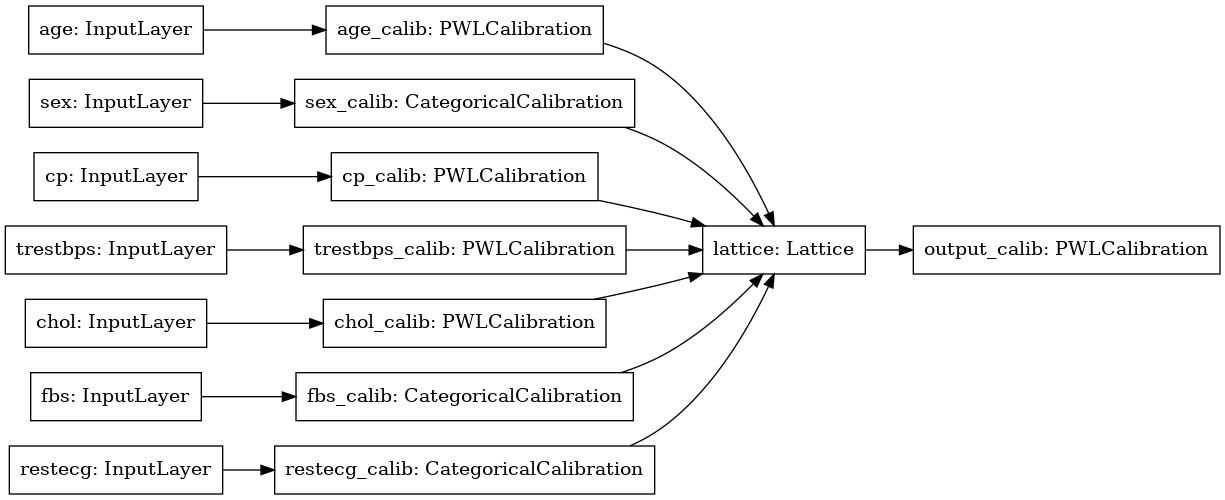

In [16]:
model = tf.keras.models.Model(
    inputs=model_inputs,
    outputs=model_output)
tf.keras.utils.plot_model(model, rankdir='LR')

训练的工作原理与其他任何 Keras 模型相同。请注意，在我们的设置中，输入特征作为单独的张量传递。

In [17]:
feature_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg']
features = np.split(
    training_data_df[feature_names].values.astype(np.float32),
    indices_or_sections=len(feature_names),
    axis=1)
target = training_data_df[['target']].values.astype(np.float32)

model.compile(
    loss=tf.keras.losses.mean_squared_error,
    optimizer=tf.keras.optimizers.Adagrad(LEARNING_RATE))
model.fit(
    features,
    target,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_split=0.2,
    shuffle=False,
    verbose=0)

model.evaluate(features, target)

 1/10 [==>...........................] - ETA: 0s - loss: 0.1400

10/10 [==============================] - 0s 3ms/step - loss: 0.1591


0.15907342731952667